In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Importing libraries

In [2]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm_notebook as tqdm
from keras.layers import Dense, LSTM, Input, Embedding, Reshape, Dropout, Add, RepeatVector, Concatenate, Dot, Lambda, Activation
import keras.backend as K
from keras.models import Model
from keras.utils import get_custom_objects

Using TensorFlow backend.


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import image, img_to_array, load_img

In [0]:
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM

In [0]:
%matplotlib inline

In [0]:
image_shape = (224, 224, 3)
feature_shape = (5, 5, 2048)

## Constants

In [0]:
BATCH_SIZE = 16
EPOCHS = 100
EMBEDDING_DIM = 100
LATENT_DIM = 256
MAX_VOCAB_SIZE=20000

## Captions

In [0]:
train_path = '/content/gdrive/My Drive/Colab Notebooks/Image Captioning/Train_GCC-training.tsv'

train_df = pd.read_csv(train_path, sep='\t', names=['captions', 'image_urls'])

In [0]:
train_captions = train_df.captions.values

## Downloaded image files

In [0]:
train_file_path = '/content/gdrive/My Drive/Colab Notebooks/Image Captioning/Training/'

In [0]:
train_image_files = [x.split('/')[-1] for x in glob(train_file_path+'*')]

## InceptionV3 model to extract features

In [12]:
base_model = InceptionV3(include_top=False, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


## Feature extraction from inceptionV3

In [0]:
def extract_features(files, files_path):
    captions_index = []
    features = []
    for i in tqdm(range(len(files))):
        try:
            img = load_img(files_path+files[i], target_size=image_shape)
            img = img_to_array(img).reshape(image_shape)
            img = preprocess_input(img)
            feature = base_model.predict(np.array([img]))[0]
            captions_index.append(int((files[i].split('_')[-1])))
            features.append(feature)
        except Exception as e:
            print(e)
    return features, captions_index

In [14]:
input_features, caption_idx = extract_features(train_image_files, train_file_path)

cannot identify image file '/content/gdrive/My Drive/Colab Notebooks/Image Captioning/Training/image_9686'
cannot identify image file '/content/gdrive/My Drive/Colab Notebooks/Image Captioning/Training/image_9700'
cannot identify image file '/content/gdrive/My Drive/Colab Notebooks/Image Captioning/Training/image_9793'
cannot identify image file '/content/gdrive/My Drive/Colab Notebooks/Image Captioning/Training/image_9848'
cannot identify image file '/content/gdrive/My Drive/Colab Notebooks/Image Captioning/Training/image_9878'
cannot identify image file '/content/gdrive/My Drive/Colab Notebooks/Image Captioning/Training/image_9986'
cannot identify image file '/content/gdrive/My Drive/Colab Notebooks/Image Captioning/Training/image_10008'
cannot identify image file '/content/gdrive/My Drive/Colab Notebooks/Image Captioning/Training/image_10218'
cannot identify image file '/content/gdrive/My Drive/Colab Notebooks/Image Captioning/Training/image_10286'
cannot identify image file '/conte

In [0]:
input_captions = np.array(train_captions)[caption_idx]

In [0]:
target_input_texts=[]
target_texts=[]

for text in input_captions:
    target_input_texts.append('<sos> '+text)
    target_texts.append(text+' <eos>')

In [17]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(target_input_texts+target_texts)
target_input_sequences = tokenizer.texts_to_sequences(target_input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

word2idx = tokenizer.word_index
max_len_target = max(len(s) for s in target_sequences)
num_words_output = len(word2idx)+1
print('no of words', num_words_output)

target_input_sequences = pad_sequences(target_input_sequences, maxlen=max_len_target, padding='post')
target_sequences = pad_sequences(target_sequences , maxlen=max_len_target, padding='post')

print('target_input_seq shape', target_input_sequences.shape)
print('target_seq shape', target_sequences.shape)


no of words 8636
target_input_seq shape (9824, 42)
target_seq shape (9824, 42)


In [0]:
def batch_generator(batch_size, data_len, input_features, input_sequences, output_sequences):
    counter = 0
    while True:
        input_f = input_features[counter*batch_size:min((counter+1)*batch_size, data_len)]
        input_s = input_sequences[counter*batch_size:min((counter+1)*batch_size, data_len)]
        output_s = output_sequences[counter*batch_size:min((counter+1)*batch_size, data_len)]
        length = min((counter+1)*batch_size, data_len)-counter*batch_size
        decoder_one_hot = np.zeros((length, max_len_target, num_words_output), dtype='float32')
        for i, d in enumerate(output_s):
            for t, word in enumerate(d):
                decoder_one_hot[i, t, word] = 1
        counter+=1
        if counter*batch_size >= data_len:
            counter=0
        z = np.zeros((length, LATENT_DIM))
        yield [input_f, input_s, z, z], decoder_one_hot

In [0]:
random_idx = np.random.randint(0, len(input_captions), len(input_captions), dtype=int)

In [0]:
validation_split = 0.2
validation_size = int(validation_split*len(input_features))
train_len = len(input_features)-validation_size

train_idx = random_idx[validation_size:]
valid_idx = random_idx[:validation_size]

In [0]:
train_input_f = np.array(input_features)[train_idx]
valid_input_F = np.array(input_features)[valid_idx]

train_input_s = np.array(target_input_sequences)[train_idx]
valid_input_s = np.array(target_input_sequences)[valid_idx]

train_output_s = np.array(target_sequences)[train_idx]
valid_output_s = np.array(target_sequences)[valid_idx]

In [0]:
train_gen = batch_generator(BATCH_SIZE, train_len, train_input_f, train_input_s, train_output_s)
valid_gen = batch_generator(BATCH_SIZE, validation_size, valid_input_F, valid_input_s, valid_output_s)

## Squashing output of base_model



In [0]:
encoder_input_placeholder = Input(feature_shape)
reshape = Reshape((25, 2048))(encoder_input_placeholder)
encoder_dense = Dense(LATENT_DIM, activation='relu')(reshape)

## Embedding layer

In [0]:
embedding_layer = Embedding(
    num_words_output,
    EMBEDDING_DIM
)

## Activation function

In [0]:
class Softmax_Over_Time(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Softmax_Over_Time, self).__init__(activation, **kwargs)
        self.__name__ = 'softmax_over_time'

def softmax_over_time(x):
#     assert(tf.keras.backend.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s


get_custom_objects().update({'softmax_over_time': Softmax_Over_Time(softmax_over_time)})

## Attention layers

In [0]:
attn_repeat_layer = RepeatVector(25)
attn_add_layer = Add()
attn_dense_1 = Dense(10, activation='tanh')
attn_dense_2 = Dense(1, activation='softmax_over_time')
attn_dot = Dot(axes=1)

In [0]:
def one_step_attention(encoded, st):
    st_1 = attn_repeat_layer(st)
    a = attn_add_layer([encoded, st_1])
    dense = attn_dense_1(a)
    alphas = attn_dense_2(dense)
    context = attn_dot([alphas, encoded])
    return context

## Decoder model

In [0]:
decoder_input_placeholder = Input((max_len_target,))
decoder_embedding = embedding_layer(decoder_input_placeholder)
decoder_lstm = LSTM(LATENT_DIM, return_state=True)
decoder_dense1 = Dense(LATENT_DIM, activation='relu')
decoder_dense2 = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM,), name='s0')
initial_c = Input(shape=(LATENT_DIM,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

## Using Teacher forcing to predict next word

In [0]:
s = initial_s
c = initial_c

outputs = []

for t in range(max_len_target):
    context = one_step_attention(encoder_dense, s)
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_embedding)
    decoder_lstm_input = context_last_word_concat_layer([context, xt])
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])
    decoder_outputs = decoder_dense1(o)
    decoder_outputs = decoder_dense2(decoder_outputs)
    outputs.append(decoder_outputs)

In [0]:
def stack_and_transpose(x):
    x = K.stack(x)
    x = K.permute_dimensions(x, pattern=(1, 0, 2))
    return x

In [0]:
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

## Training the model

In [0]:
model = Model(
  inputs=[
    encoder_input_placeholder,
    decoder_input_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
r = model.fit_generator(train_gen,
                       epochs=EPOCHS,
                       steps_per_epoch=train_len//BATCH_SIZE,
                       validation_data=valid_gen,
                       validation_steps=validation_size//BATCH_SIZE)


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
491/491 [==============================] - 64s 130ms/step - loss: 1.9092 - acc: 0.7529 - val_loss: 1.5926 - val_acc: 0.7688
Epoch 2/100
491/491 [==============================] - 52s 106ms/step - loss: 1.5181 - acc: 0.7728 - val_loss: 1.5356 - val_acc: 0.7739
Epoch 3/100
491/491 [==============================] - 52s 106ms/step - loss: 1.4385 - acc: 0.7768 - val_loss: 1.4867 - val_acc: 0.7784
Epoch 4/100
491/491 [==============================] - 52s 107ms/step - loss: 1.3534 - acc: 0.7810 - val_loss: 1.4390 - val_acc: 0.7824
Epoch 5/100
491/491 [==============================] - 53s 108ms/step - loss: 1.2741 - acc: 0.7856 - val_loss: 1.4238 - val_acc: 0.7855
Epoch 6/100
491/491 [==============================] - 53s 108ms/step - loss: 1.2003 - acc: 0.7903 - val_loss: 1.4073 - val_acc: 0.7887
Epoch 7/100
491/491 [==============================] - 52s

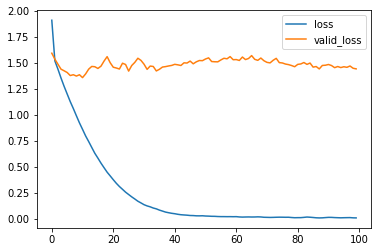

In [34]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='valid_loss')
plt.legend()
plt.show()

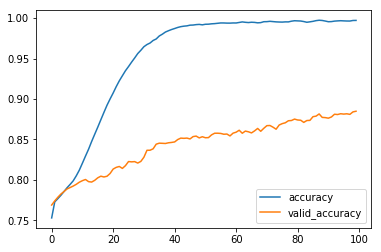

In [35]:
plt.plot(r.history['acc'], label='accuracy')
plt.plot(r.history['val_acc'], label='valid_accuracy')
plt.legend()
plt.show()

In [0]:
encoder_model = Model(inputs=encoder_input_placeholder, outputs=encoder_dense)

decoder_state_input_h = Input((LATENT_DIM,))
decoder_state_input_c = Input((LATENT_DIM,))
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]

decoder_encoder_placeholder = Input((25, LATENT_DIM))

decoder_input_placeholder = Input((1,)) 
decoder_embedding = embedding_layer(decoder_input_placeholder)
decoder_context = one_step_attention(decoder_encoder_placeholder, decoder_state_input_h)
decoder_concat_last_word = context_last_word_concat_layer([decoder_context, decoder_embedding])
decoder_output, h, c = decoder_lstm(decoder_concat_last_word, initial_state=decoder_states_input)
decoder_states = [h, c]
decoder_output = decoder_dense1(decoder_output)
decoder_output = decoder_dense2(decoder_output)
decoder_model = Model(inputs=[decoder_encoder_placeholder,decoder_input_placeholder]+decoder_states_input, outputs=[decoder_output]+decoder_states)

In [0]:
idx2word = {v:k for k,v in word2idx.items()}

In [0]:
def output_cation(files_path, input_image_file):
    
    img = None
    
    try:
        img = load_img(files_path+input_image_file, target_size=image_shape)
        img = img_to_array(img).reshape(image_shape)
        img = preprocess_input(img)
    except Exception as e:
        print(e)
        return
    
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx['<sos>']
    
    states_value = [np.zeros((1, LATENT_DIM)), np.zeros((1, LATENT_DIM))]
    eos = word2idx['<eos>']
    
    input_feature = base_model.predict(np.array([img]))
    encoded_input = encoder_model.predict(input_feature)
    output_sentencs = []
    
    plt.imshow(img)
    plt.show()
    
    for _ in range(max_len_target):
                
        output, h, c = decoder_model.predict([encoded_input, target_seq]+states_value)
        
        idx = np.argmax(output[0,:])
        
        if idx == eos:
            break
        
        word = ''
        if idx>0:
            word = idx2word[idx]
            output_sentencs.append(word)
        
        target_seq = np.array([idx])
        states_value = [h, c]
    
    return ' '.join(output_sentencs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


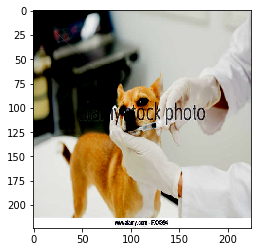

---
Input: veterinarian giving an injection to a dog
Translation: my smiling sheep in an apartment building in the area , which is clear other
Continue [Y/n]?y


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


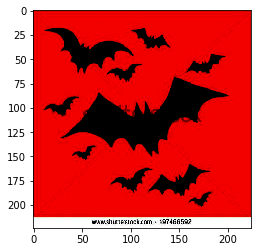

---
Input: halloween , set of bats flying on an orange background
Translation: it 's this tower who is like an apartment in the heart .
Continue [Y/n]?y


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


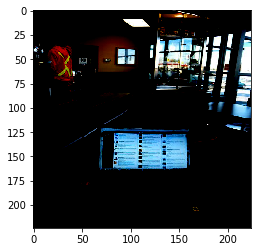

---
Input: my laptop on a table
Translation: my dog operating into the fifties
Continue [Y/n]?


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


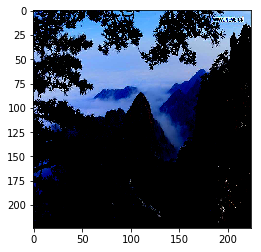

---
Input: photo taken shows the sea of clouds after a snowfall at the scenic spot .
Translation: photo taken shows the sea of clouds after a snowfall at the scenic spot .
Continue [Y/n]?y


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


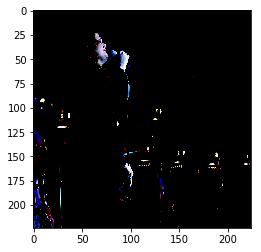

---
Input: synthpop artist performs on stage with the orchestra .
Translation: acoustic people playing with team as the last fun
Continue [Y/n]?y


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


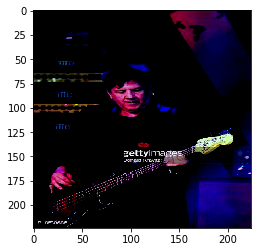

---
Input: singer of band performs in concert
Translation: rock artist performs .
Continue [Y/n]?y


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


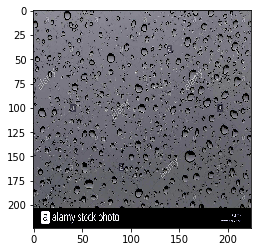

---
Input: drop of water for the background on glass car window to abstract design and nature backdrop
Translation: group of fireworks on a flower
Continue [Y/n]?y


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


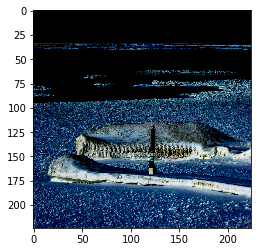

---
Input: a city also beautiful in the winter
Translation: a city also seen across the water
Continue [Y/n]?n


In [75]:
while True:
    i = np.random.choice(len(train_image_files))
    input_image_file = train_image_files[i]
    translation = output_cation(train_file_path, input_image_file)
    if translation:
        print('---')
        print('Input: '+train_captions[int(input_image_file.split('_')[-1])])
        print('Translation: '+translation)
    
    ans = input("Continue [Y/n]?")
    if ans and ans.lower().startswith('n'):
        break